## The Waterfall Plots for SHAP Values of Any Models

* Please read [Explain your model with the SHAP values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) and [The SHAP with More Elegant Charts](https://dataman-ai.medium.com/the-shap-with-more-elegant-charts-bc3e73fa1c0c)

### Table of Contents
* [Section 1: Matplotlib](#section1)
    * [Section 1.1: Random forest](#section11)
    * [Section 1.2: XGB](sSection12)
* [Section 2: Plotly](#section2)
    * [Section 2.1: Random forest](#section21)
    * [Section 2.2: XGB](#section22)

In [1]:
from sklearn.model_selection import train_test_split
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

path = "/Downloads"
df = pd.read_csv(path + '/winequality-red.csv')

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Y = np.where(df['quality']>6,1,0)
X =  df[features]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)
df['quality'] = df['quality'].astype(int)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:>

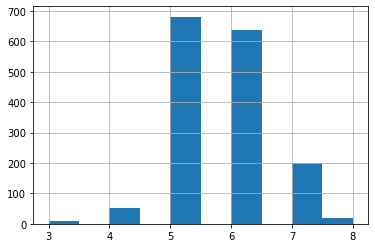

In [2]:
df['quality'].hist()

## (1) Matplotlib <a class="anchor" id="section1"></a>

### (1.1) Random forest <a class="anchor" id="section11"></a>



In [3]:
# Build the model with the random forest regression algorithm:
rf_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf_model.fit(X_train, Y_train).score(X_train,Y_train)

0.6940550067343673

In [4]:
rf_model_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_model_explainer.shap_values(X_test)
base_value = Y_train.mean()
Y_pred_prob = rf_model.predict(X_test)
Y_pred = np.where(Y_pred_prob>base_value,1,0)

### (1.2) Waterfall plot  <a class="anchor" id="section12"></a>

In [5]:
import numpy as np
import pandas as pd

class waterfall():
    def __init__(self, data, shap_values, 
                       base_value, 
                       path = "",
                       green_color ='#29EA38' , 
                       red_color = '#FB3C62', 
                       n=8,
                       title="The Prediction " ,
                       x_lab="",
                       y_lab="The predicted value",
                       formatting = "{:,.2f}",
                       rotation_value = 90,
                       figsize = (7,5)
                
                ):
        self.data        = data
        self.shap_values = shap_values
        self.base_value  = base_value
        self.green_color = green_color
        self.red_color   = red_color
        self.n           = n
        self.title       = title
        self.x_lab       = x_lab
        self.y_lab       = y_lab
        self.formatting  = formatting
        self.rotation_value = rotation_value
        self.figsize     = figsize
        self._plot       = pd.DataFrame()
        self.path        = path

    def obs_to_explain(self):
        '''
          - data: the observation. It is a Pandas series. The index contains the variable names 
          - shap_values: the shap_values for the above observation 
          - base_value: the base_value, which is the expected value or the mean of the target value of the training set
          - green_color: the color for the up bar
          - red_color: the color for the down bar
          - for_plot: a sorted data frame by the absolute value of shape in descending order
          - n: show the top n (default) variables. The rest variables are summed up into "others"
        '''
        for_plot = pd.DataFrame({'data':np.round(self.data,2),
                                 'shap':self.shap_values,
                                 'shap_abs': np.abs(self.shap_values),
                                 'label': self.data.index
                                })
        for_plot = for_plot.sort_values(by='shap_abs',ascending=False)

        # Split the variables into n and the rest. Only show the top n
        for_plot1 = for_plot.iloc[0:self.n,:]
        for_plot2 = for_plot.iloc[self.n:,:]

        # Sum up the rest as 'others'
        rest = pd.DataFrame({'data': '','shap':for_plot2['shap'].sum(), 'label': 'Others'},index=['others'])
        for_plot = for_plot1.append(rest)

        # Sum up the rest into 'others'
        base = pd.DataFrame({'data': np.round(self.base_value,2),'shap':self.base_value, 'label': 'Base value'},index=['base_value'])
        for_plot = base.append(for_plot)

        for_plot['blank'] = for_plot['shap'].cumsum().shift(1).fillna(0) # +  base_value
        for_plot['label'] = + for_plot['label'] + " =" + for_plot['data'].map(str) 
        for_plot['color'] = np.where(for_plot['shap']>0,self.green_color,self.red_color)
        for_plot = for_plot.drop(['data','shap_abs'],axis=1)
        
        self.for_plot = for_plot
        
        return(for_plot ) 
    
    def plt_plot(self):
        '''
          - x_lab, y_lab: the x label and y label
          - formatting: show the value of each bar 
        '''

        fig, ax = plt.subplots(figsize=self.figsize)

        # Plot the waterfall    
        plt.bar(range(0,len(self.for_plot.index)), self.for_plot['shap'], width=0.6,
              bottom=self.for_plot['blank'],     color=self.for_plot['color'])     

        #axis labels
        plt.xlabel("\n" + self.x_lab)
        plt.ylabel(self.y_lab + "\n")

        #Get the y-axis position for the labels
        y_height = self.for_plot.shap.cumsum().shift(1).fillna(0)

        plot_max = self.for_plot['shap'].max()
        plot_min = self.for_plot['shap'].min()
        pos_offset = plot_max / 40
        plot_offset = plot_max / 15 
        total = self.for_plot.sum().shap 

        # label the shap values
        loop = 0
        for index, row in self.for_plot.iterrows():
            # For the last item in the list, we don't want to double count
            if row['shap'] == total:
                    y = y_height[loop]
            else:
                    y = y_height[loop] + row['shap']

            if row['shap'] > 0:
                    y += (pos_offset*2)
                    plt.annotate(self.formatting.format(row['shap']),(loop,y),ha="center", color = self.green_color, fontsize=10)
            else:
                    y -= (pos_offset*4)
                    plt.annotate(self.formatting.format(row['shap']),(loop,y),ha="center", color = self.red_color, fontsize=10)
            loop+=1

        # Range of the ylim
        plt.ylim(plot_min-round(3.6*plot_offset, 7) ,plot_max+round(3.6*plot_offset, 7))

        #Rotate the labels
        plt.xticks(range(0,len(self.for_plot)), self.for_plot['label'], rotation=self.rotation_value)

        #add the base value line and title
        #plt.axhline(base_value, color='black', linewidth = 0.6, linestyle="dashed")
        plt.title(self.title)

        import matplotlib.patches as mpatches
        red_patch = mpatches.Patch(color=self.red_color, label='Down')
        green_patch = mpatches.Patch(color=self.green_color, label='Up')
        plt.legend(handles=[red_patch,green_patch],bbox_to_anchor=[1, 1], loc='upper left')

        #plt.tight_layout()
        #return(fig)
    
    def plotly_plot(self):
        import plotly.graph_objects as go
        import numpy as np

        ys = self.for_plot['shap'].round(2)
        ms = list(np.repeat('relative',len(ys)))
        xs = list(self.for_plot['label'].values)
        texts = self.for_plot['shap'].round(2)

        fig = go.Figure(go.Waterfall(
            name = "20", orientation = "v",
            measure = ms,
            x = xs,
            textposition = "outside",
            text = texts,
            y = ys,
            connector = {"line":{"color":"rgb(63, 63, 63)"} },
           ) )


        layout = go.Layout(
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)'
        )

        fig.update_layout(
            template="plotly_white",
            title ="The prediction of this observation is " ,
            margin=dict(l=120, r=120, t=60, b=60),
            yaxis=dict(
                title_text="The predicted value" 
            ),
            xaxis =dict(
                tickangle = -90,
                title_text = "Variables")
        )
        fig.write_html(self.path + "/f.html", auto_open=True)
    
    

In [6]:
obs = 10
rf_shap_to = waterfall(X_test.iloc[obs,:],
                              base_value = base_value,
                              shap_values = rf_shap_values[obs],
                              path = path,
                              title="The Prediction " ,
                              x_lab="",
                              y_lab="The predicted value",
                              formatting = "{:,.2f}",
                              rotation_value = 90,
                              figsize = (7,5)
                      
                      )
rf_shap_to.obs_to_explain()

,shap,label,blank,color
base_value,0.137608,Base value =0.14,0.000000,#29EA38
alcohol,-0.055662,alcohol =9.5,0.137608,#FB3C62
total sulfur dioxide,-0.036046,total sulfur dioxide =81.0,0.081945,#FB3C62
sulphates,-0.022881,sulphates =0.54,0.045899,#FB3C62
volatile acidity,-0.019963,volatile acidity =0.72,0.023018,#FB3C62
free sulfur dioxide,0.014723,free sulfur dioxide =13.0,0.003055,#29EA38
citric acid,-0.004883,citric acid =0.22,0.017778,#FB3C62
density,-0.003330,density =1.0,0.012895,#FB3C62
residual sugar,-0.003327,residual sugar =2.3,0.009564,#FB3C62
others,-0.000794,Others =,0.006237,#FB3C62


The predicted value is: 0.005
The expected value is: 0.138
The predicted group is: 0
The Actual value is: 0


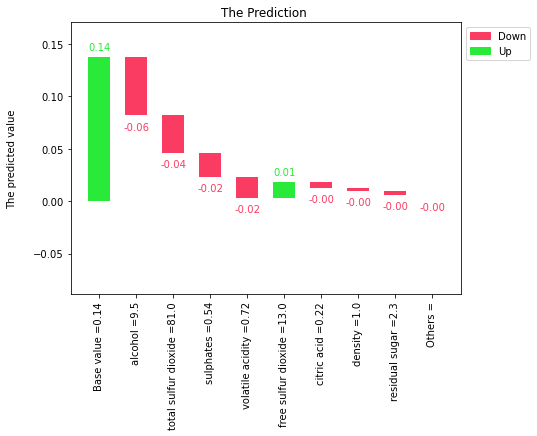

In [7]:
obs =10
print("The predicted value is: " +  str(np.round(Y_pred_prob[obs],3)))
print("The expected value is: " +  str(np.round(base_value,3)))
print("The predicted group is: " +  str(np.round(Y_pred[obs],0)))
print("The Actual value is: " +  str(np.round(Y_test[obs],3)))
rf_shap_to.obs_to_explain()
rf_shap_to.plt_plot()

### (1.2) XGB <a class="anchor" id="section12"></a>

In [8]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, Y_train).score(X_train,Y_train)

0.999638222863754

In [9]:
xgb_model_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_model_explainer.shap_values(X_test)
base_value = Y_train.mean()
Y_pred_prob = xgb_model.predict(X_test)
Y_pred = np.where(Y_pred_prob>base_value,1,0)

In [10]:
obs = 10
xgb_shap_to = waterfall(X_test.iloc[obs,:],
                              base_value = base_value,
                              shap_values = xgb_shap_values[obs],
                              path = path,
                              title="The Prediction " ,
                              x_lab="",
                              y_lab="The predicted value",
                              formatting = "{:,.2f}",
                              rotation_value = 90,
                              figsize = (7,5)
                      
                      )

The predicted value is: 0.001
The expected value is: 0.138
The predicted group is: 0
The Actual value is: 0


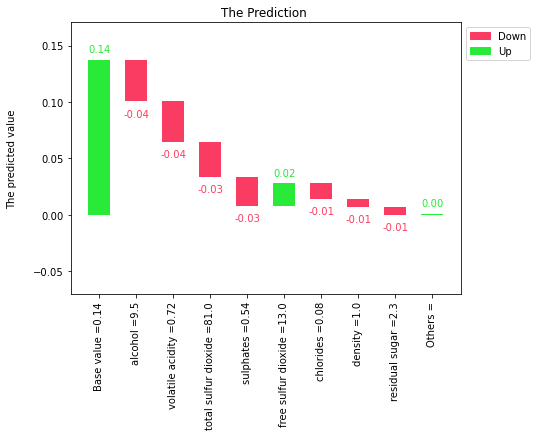

In [11]:
obs =10
print("The predicted value is: " +  str(np.round(Y_pred_prob[obs],3)))
print("The expected value is: " +  str(np.round(base_value,3)))
print("The predicted group is: " +  str(np.round(Y_pred[obs],0)))
print("The Actual value is: " +  str(np.round(Y_test[obs],3)))

xgb_shap_to.obs_to_explain()
xgb_shap_to.plt_plot()

## (2) Plotly <a class="anchor" id="section2"></a>

### (2.1) Random forest <a class="anchor" id="section21"></a>

In [12]:
obs =10
print("The predicted value is: " +  str(np.round(Y_pred_prob[obs],3)))
print("The expected value is: " +  str(np.round(base_value,3)))
print("The predicted group is: " +  str(np.round(Y_pred[obs],0)))
print("The Actual value is: " +  str(np.round(Y_test[obs],3)))

rf_shap_to.obs_to_explain()
rf_shap_to.plotly_plot()

The predicted value is: 0.001
The expected value is: 0.138
The predicted group is: 0
The Actual value is: 0


### (2.2) XGB <a class="anchor" id="section22"></a>

In [52]:
xgb_model_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_model_explainer.shap_values(X_test)
base_value = Y_train.mean()
Y_pred_prob = xgb_model.predict(X_test)
Y_pred = np.where(Y_pred_prob>base_value,1,0)

In [53]:
obs =10
print("The predicted value is: " +  str(np.round(Y_pred_prob[obs],3)))
print("The expected value is: " +  str(np.round(base_value,3)))
print("The predicted group is: " +  str(np.round(Y_pred[obs],0)))
print("The Actual value is: " +  str(np.round(Y_test[obs],3)))

xgb_shap_to.obs_to_explain()
xgb_shap_to.plotly_plot()

The predicted value is: 0.001
The expected value is: 0.138
The predicted group is: 0
The Actual value is: 0
